# Stack Overflow Topic Classification using RNN

Author: Jash Dubal

 ## Imports

In [1]:
import torch
import pandas as pd
from torchtext import data
import warnings as wrn
wrn.filterwarnings('ignore')
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.0.0+cu118


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load the data

In [5]:
# Load Stack Overflow data into a pandas dataframe
# Ensure dataset/SO.csv exists
try:
  df = pd.read_csv('dataset/SO.csv')
  print('df loaded successfully!')
except Exception as e:
  print('dataset/SO.csv not found')

df loaded successfully!


In [6]:
# Show first rows of dataframe
df.head()

,Title,Label
0,Different rlike behavior in Spark 1.6 and Spar...,spark
1,Getting a column as concatenated column from a...,spark
2,Write data using JDBC connection to Azure SQL ...,spark
3,Get value from external client database for a ...,spark
4,How to setup Apache Spark to use local hard di...,spark


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Title   150000 non-null  object
 1   Label   150000 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


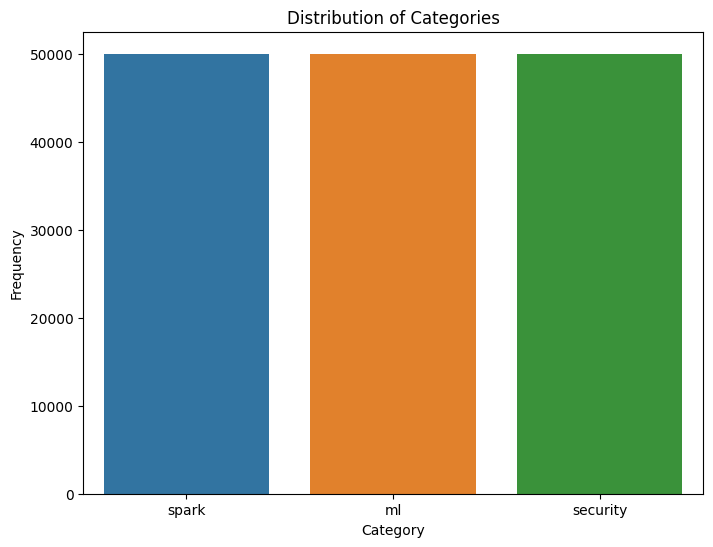

In [8]:
# This cell generates a bar plot to visualize the distribution of categories in the dataset.
# The purpose of this plot is to understand the class balance and any potential biases in the dataset.

import seaborn as sns

# Set the figure size
plt.figure(figsize=(8, 6))

# Generate a count plot using Seaborn
sns.countplot(data=df, x='Label')

# Set the title and labels for the plot
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [9]:
# Dataframe target distribution
df['Label'].value_counts()

spark       50000
ml          50000
security    50000
Name: Label, dtype: int64

## Preprocess natural language text
Steps:
- Remove non-alphabetical characters
- Convert to lowercase
- Remove stopwords
- Lemmatize
- Tokenize

In [15]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


nltk.download('averaged_perceptron_tagger')

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A text preprocessor that removes non-alphabetic characters, converts text to lowercase,
    tokenizes text, removes stopwords, and lemmatizes text with POS tagging.
    """
    
    def __init__(self):
        """
        Initializes a new TextPreprocessor object with a WordNetLemmatizer and a set of stopwords.
        """
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def get_wordnet_pos(self, word):
        """
        Maps the POS tag to the first character that the lemmatize() function accepts.
        
        Parameters:
        - word (str): a word to be lemmatized
        
        Returns:
        - wordnet tag (str): a wordnet tag for the word to be lemmatized
        """
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
    def _preprocess(self, text):
        """
        Applies a series of text preprocessing steps to a string of text.
        
        Parameters:
        - text (str): a string of text to be preprocessed
        
        Returns:
        - tokens (list): a list of preprocessed and lemmatized tokens
        """
        # Remove non-alphabetic characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        # Lemmatize text with POS tagging
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) for token in tokens]
        # Return tokenized text
        return tokens

    def fit(self, X, y=None):
        """
        Fits the TextPreprocessor to the input data X.
        
        Parameters:
        - X (pandas.Series): a series of text data
        
        Returns:
        - self (TextPreprocessor): returns the TextPreprocessor object
        """
        return self
    
    def transform(self, X, y=None):
        """
        Applies the TextPreprocessor to the input data X and returns the preprocessed data.
        
        Parameters:
        - X (pandas.Series): a series of text data
        
        Returns:
        - X_processed (pandas.Series): the preprocessed data as a pandas series
        """
        X_processed = X.apply(self._preprocess)
        return X_processed

preprocessor = TextPreprocessor()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
# Create a new column cleaning the title of the post
df['Clean_Title'] = preprocessor.transform(df['Title'])

In [17]:
df.head()

,Title,Label,Clean_Title
0,Different rlike behavior in Spark 1.6 and Spar...,spark,"[different, rlike, behavior, spark, spark]"
1,Getting a column as concatenated column from a...,spark,"[get, column, concatenate, column, reference, ..."
2,Write data using JDBC connection to Azure SQL ...,spark,"[write, data, use, jdbc, connection, azure, sq..."
3,Get value from external client database for a ...,spark,"[get, value, external, client, database, colum..."
4,How to setup Apache Spark to use local hard di...,spark,"[setup, apache, spark, use, local, hard, disk,..."


Use GloVe word embeddings to convert list of words to vectors.

In [18]:
import torch
from torchtext.vocab import GloVe

# Load pre-trained GloVe embeddings with 100-dimensional vectors
glove = GloVe(name='6B', dim=100)

def vectorize_text(tokens, embeddings):
    """
    Convert a list of tokens to a PyTorch tensor of embeddings.

    Args:
    tokens: list of strings representing tokens
    embeddings: pre-trained word embeddings to use for vectorization

    Returns:
    a PyTorch tensor of size (num_tokens, embedding_dim) containing the embeddings of the tokens
    """
    if not tokens:
        # Return an empty tensor if no tokens are present
        return torch.tensor([])
    # Stack the embeddings of each token to form the final tensor
    return torch.stack([embeddings[token] for token in tokens])

# Add a new column 'Vectorized_Title' to the DataFrame, containing the vectorized form of 'Clean_Title'
df['Vectorized_Title'] = df['Clean_Title'].apply(lambda x: vectorize_text(x, glove))

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21466.11it/s]


In [19]:
df.head()

,Title,Label,Clean_Title,Vectorized_Title
0,Different rlike behavior in Spark 1.6 and Spar...,spark,"[different, rlike, behavior, spark, spark]","[[tensor(-0.3419), tensor(0.6998), tensor(-0.0..."
1,Getting a column as concatenated column from a...,spark,"[get, column, concatenate, column, reference, ...","[[tensor(0.1443), tensor(0.4395), tensor(0.583..."
2,Write data using JDBC connection to Azure SQL ...,spark,"[write, data, use, jdbc, connection, azure, sq...","[[tensor(-0.5106), tensor(0.4867), tensor(-0.0..."
3,Get value from external client database for a ...,spark,"[get, value, external, client, database, colum...","[[tensor(0.1443), tensor(0.4395), tensor(0.583..."
4,How to setup Apache Spark to use local hard di...,spark,"[setup, apache, spark, use, local, hard, disk,...","[[tensor(-0.2554), tensor(0.2010), tensor(0.49..."


In [20]:
# Check the shape of the first vector to ensure it is a 100-dimensional vector according to the GloVe embeddings
df['Vectorized_Title'][0].shape

torch.Size([5, 100])

In [21]:
# Filter out all rows that have empty tensors
df = df[df["Vectorized_Title"].apply(lambda x: len(x) > 0)]

## Splitting
Split data into train, validation, test set

In [22]:
# This cell splits the dataset into train, validation, and test sets using an 80/20 split for train/test and 
# further splitting the train set with an 80/20 ratio for train/validation.
# The split is stratified by the 'Label' column to maintain the class distribution in each split.

# Import the required library
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets with an 80/20 split, stratified by the 'Label' column
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Split the train dataset into train and validation sets with an 80/20 split, stratified by the 'Label' column
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Label'])

Ensure that the split has even distribution of classes

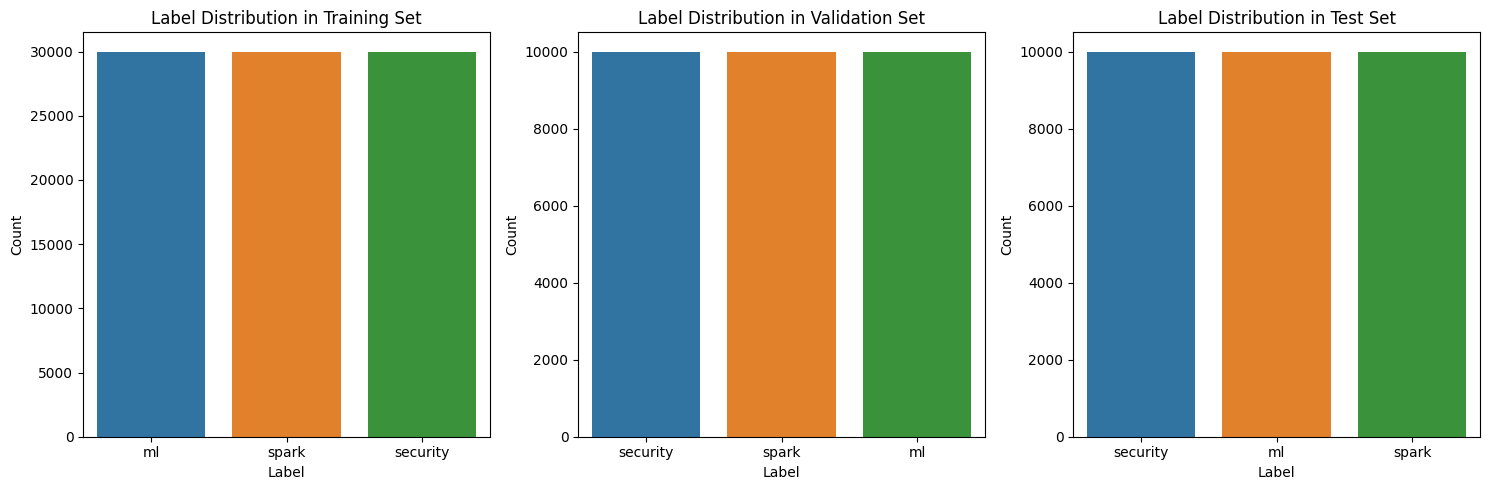

Label Distribution in Training Set
ml          30000
spark       30000
security    29999
Name: Label, dtype: int64
Label Distribution in Validation Set
security    10000
spark       10000
ml          10000
Name: Label, dtype: int64
Label Distribution in Test Set
security    10000
ml          10000
spark       10000
Name: Label, dtype: int64


In [23]:
# This cell generates bar plots to visualize the distribution of labels in the training, validation, and test sets.
# The purpose of these plots is to confirm that the stratified split has maintained the class distribution in each split.

import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(df, title, subplot_loc):
    # Function that creates a bar plot for the label distribution of a given DataFrame
    plt.subplot(subplot_loc)
    label_counts = df['Label'].value_counts()
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')

# Create a 1x3 grid of subplots
plt.figure(figsize=(15, 5))

def print_label_distribution(df, title):
    # Function that prints the label distribution of a given DataFrame
    label_counts = df['Label'].value_counts()
    print(title)
    print(label_counts)

# Plot label distributions for each dataset
plot_label_distribution(train_df, 'Label Distribution in Training Set', 131)
plot_label_distribution(val_df, 'Label Distribution in Validation Set', 132)
plot_label_distribution(test_df, 'Label Distribution in Test Set', 133)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

# Print label distributions for each dataset
print_label_distribution(train_df, 'Label Distribution in Training Set')
print_label_distribution(val_df, 'Label Distribution in Validation Set')
print_label_distribution(test_df, 'Label Distribution in Test Set')


## Build the model

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class StackOverflowDataset(Dataset):
    """
    A custom Dataset class for StackOverflow data.
    """
    def __init__(self, df, label_to_idx):
        """
        Initializes a new StackOverflowDataset object.
        
        Args:
        df (pandas.DataFrame): the DataFrame containing the data
        label_to_idx (dict): a dictionary mapping labels to their corresponding index values
        """
        self.df = df
        self.label_to_idx = label_to_idx

    def __len__(self):
        """
        Returns the length of the dataset.
        
        Returns:
        int: the number of samples in the dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the specified index.
        
        Args:
        idx (int): the index of the sample to retrieve
        
        Returns:
        tuple: a tuple containing the vectorized title (torch.Tensor) and the label (torch.Tensor)
        """
        text = torch.stack(list(self.df.iloc[idx]["Vectorized_Title"]))
        label = torch.tensor(self.label_to_idx[self.df.iloc[idx]["Label"]], dtype=torch.long)
        return text, label

def collate_batch(batch):
    """
    A custom collate function to pad the text sequences in a batch to the same length.
    
    Args:
    batch (list): a list of samples (text, label) to be collated
    
    Returns:
    tuple: a tuple containing the padded texts (torch.Tensor) and labels (torch.Tensor)
    """
    texts, labels = zip(*batch)
    text_lens = [len(text) for text in texts]
    max_len = max(text_lens)
    padded_texts = [torch.cat([text, torch.zeros(max_len - len(text), 100)]) for text in texts]
    return torch.stack(padded_texts), torch.tensor(labels, dtype=torch.long)

In [25]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    A custom LSTM-based classifier for text classification.
    """
    def __init__(self, embed_dim, hidden_dim, num_classes, dropout=0.5):
        """
        Initializes a new LSTMClassifier object.
        
        Args:
        embed_dim (int): the dimension of the word embeddings
        hidden_dim (int): the size of the hidden state in the LSTM layer
        num_classes (int): the number of classes in the classification task
        dropout (float, optional): the dropout probability (default: 0.5)
        """
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        """
        Defines the forward pass for the LSTMClassifier.
        
        Args:
        text (torch.Tensor): the input text tensor
        
        Returns:
        torch.Tensor: the logits for the classification task
        """
        lstm_out, _ = self.lstm(text)
        pooled = self.dropout(torch.mean(lstm_out, dim=1))
        logits = self.fc(pooled)
        return logits

class GRUClassifier(nn.Module):
    """
    A custom GRU-based classifier for text classification.
    """
    def __init__(self, embed_dim, hidden_dim, num_classes, dropout=0.5):
        """
        Initializes a new GRUClassifier object.
        
        Args:
        embed_dim (int): the dimension of the word embeddings
        hidden_dim (int): the size of the hidden state in the GRU layer
        num_classes (int): the number of classes in the classification task
        dropout (float, optional): the dropout probability (default: 0.5)
        """
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        """
        Defines the forward pass for the GRUClassifier.
        
        Args:
        text (torch.Tensor): the input text tensor
        
        Returns:
        torch.Tensor: the logits for the classification task
        """
        gru_out, _ = self.gru(text)
        pooled = self.dropout(torch.mean(gru_out, dim=1))
        logits = self.fc(pooled)
        return logits

In [26]:
# Create a dictionary to map labels to their corresponding index values
label_to_idx = {"spark": 0, "ml": 1, "security": 2}

# Initialize the StackOverflowDataset objects for training, validation, and testing
train_dataset = StackOverflowDataset(train_df, label_to_idx)
val_dataset = StackOverflowDataset(val_df, label_to_idx)
test_dataset = StackOverflowDataset(test_df, label_to_idx)

# Set the batch size for data loading
batch_size = 64

# Initialize DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

## Training

In [27]:
import torch.optim as optim

def train_and_evaluate(model, num_epochs=10):
    """
    Trains and evaluates a given PyTorch model on the train and validation datasets,
    and tests the model on the test dataset.
    
    Args:
    model: PyTorch model to be trained and evaluated
    num_epochs: Number of epochs to train the model (default: 10)
    
    Returns:
    true_labels: List of true labels for the test dataset
    pred_labels: List of predicted labels for the test dataset
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Train and evaluate the model
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for texts, labels in train_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(texts)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_dataloader:
                texts, labels = texts.to(device), labels.to(device)
                logits = model(texts)
                loss = criterion(logits, labels)
                val_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Testing
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for texts, labels in test_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            logits = model(texts)
            predictions = torch.argmax(logits, dim=-1)
            true_labels.extend(labels.tolist())
            pred_labels.extend(predictions.tolist())
    
    return true_labels, pred_labels

embed_dim = 100
hidden_dim = 128
num_classes = 3

lstm_model = LSTMClassifier(embed_dim, hidden_dim, num_classes)
print("Training and evaluating LSTM model:")
lstm_true_labels, lstm_pred_labels = train_and_evaluate(lstm_model)

gru_model = GRUClassifier(embed_dim, hidden_dim, num_classes)
print("\nTraining and evaluating GRU model:")
gru_true_labels, gru_pred_labels = train_and_evaluate(gru_model)

Training and evaluating LSTM model:
Epoch 1/10 | Train Loss: 0.3794 | Val Loss: 0.2864
Epoch 2/10 | Train Loss: 0.2657 | Val Loss: 0.2542
Epoch 3/10 | Train Loss: 0.2362 | Val Loss: 0.2426
Epoch 4/10 | Train Loss: 0.2145 | Val Loss: 0.2349
Epoch 5/10 | Train Loss: 0.2001 | Val Loss: 0.2355
Epoch 6/10 | Train Loss: 0.1855 | Val Loss: 0.2321
Epoch 7/10 | Train Loss: 0.1732 | Val Loss: 0.2329
Epoch 8/10 | Train Loss: 0.1616 | Val Loss: 0.2507
Epoch 9/10 | Train Loss: 0.1493 | Val Loss: 0.2517
Epoch 10/10 | Train Loss: 0.1395 | Val Loss: 0.2609

Training and evaluating GRU model:
Epoch 1/10 | Train Loss: 0.3586 | Val Loss: 0.2856
Epoch 2/10 | Train Loss: 0.2597 | Val Loss: 0.2620
Epoch 3/10 | Train Loss: 0.2314 | Val Loss: 0.2410
Epoch 4/10 | Train Loss: 0.2138 | Val Loss: 0.2355
Epoch 5/10 | Train Loss: 0.1961 | Val Loss: 0.2308
Epoch 6/10 | Train Loss: 0.1833 | Val Loss: 0.2306
Epoch 7/10 | Train Loss: 0.1701 | Val Loss: 0.2359
Epoch 8/10 | Train Loss: 0.1552 | Val Loss: 0.2360
Epoch 9/1

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_roc_auc(true_labels, pred_labels, num_classes):
    """
    Computes ROC curves and AUC scores for multiclass classification.
    
    Args:
    true_labels: List of true labels for the dataset
    pred_labels: List of predicted labels for the dataset
    num_classes: Number of classes in the classification problem
    
    Returns:
    fpr: Dictionary containing false positive rates for each class
    tpr: Dictionary containing true positive rates for each class
    roc_auc: Dictionary containing ROC AUC scores for each class
    """
    true_labels_bin = label_binarize(true_labels, classes=range(num_classes))
    pred_labels_bin = label_binarize(pred_labels, classes=range(num_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

lstm_fpr, lstm_tpr, lstm_roc_auc = compute_roc_auc(lstm_true_labels, lstm_pred_labels, num_classes)
gru_fpr, gru_tpr, gru_roc_auc = compute_roc_auc(gru_true_labels, gru_pred_labels, num_classes)

In [31]:
from sklearn.metrics import classification_report

print("LSTM Model Performance:")
print(classification_report(lstm_true_labels, lstm_pred_labels, target_names=list(label_to_idx.keys()), digits=4))


print("GRU Model Performance:")
print(classification_report(gru_true_labels, gru_pred_labels, target_names=list(label_to_idx.keys()), digits=4))

LSTM Model Performance:
              precision    recall  f1-score   support

       spark     0.8997    0.9087    0.9042     10000
          ml     0.9204    0.8933    0.9066     10000
    security     0.9264    0.9444    0.9353     10000

    accuracy                         0.9155     30000
   macro avg     0.9155    0.9155    0.9154     30000
weighted avg     0.9155    0.9155    0.9154     30000

GRU Model Performance:
              precision    recall  f1-score   support

       spark     0.8938    0.9135    0.9036     10000
          ml     0.9151    0.8930    0.9039     10000
    security     0.9332    0.9352    0.9342     10000

    accuracy                         0.9139     30000
   macro avg     0.9140    0.9139    0.9139     30000
weighted avg     0.9140    0.9139    0.9139     30000



Based on the validation metrics, it appears that both models perform similarly. We can observe the ROC curve to determine which model to perform hyperparameter tuning on.

In [38]:
import numpy as np

def plot_separate_roc_curves(lstm_fpr, lstm_tpr, lstm_roc_auc, gru_fpr, gru_tpr, gru_roc_auc):
    """
    This function plots separate ROC curves for the LSTM and GRU classifiers for each class.
    
    Parameters:
    lstm_fpr (dict): A dictionary containing false positive rates for each class in the LSTM classifier.
    lstm_tpr (dict): A dictionary containing true positive rates for each class in the LSTM classifier.
    lstm_roc_auc (dict): A dictionary containing the area under the ROC curve for each class in the LSTM classifier.
    gru_fpr (dict): A dictionary containing false positive rates for each class in the GRU classifier.
    gru_tpr (dict): A dictionary containing true positive rates for each class in the GRU classifier.
    gru_roc_auc (dict): A dictionary containing the area under the ROC curve for each class in the GRU classifier.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for ax, model_name, fpr, tpr, roc_auc in zip(axes, ['LSTM', 'GRU'], [lstm_fpr, gru_fpr], [lstm_tpr, gru_tpr], [lstm_roc_auc, gru_roc_auc]):
        for i, label in enumerate(label_to_idx.keys()):
            ax.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.4f})")
        
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{model_name} ROC Curve")
        ax.legend(loc="lower right")
        
        total_auc = np.mean(list(roc_auc.values()))
        ax.text(0.6, 0.3, f"Average AUC= {total_auc:.4f}", fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.tight_layout()
    plt.suptitle("LSTM and GRU ROC Curves for Classifying Stack Overflow Posts", fontsize=16, y=1.05)
    plt.show()

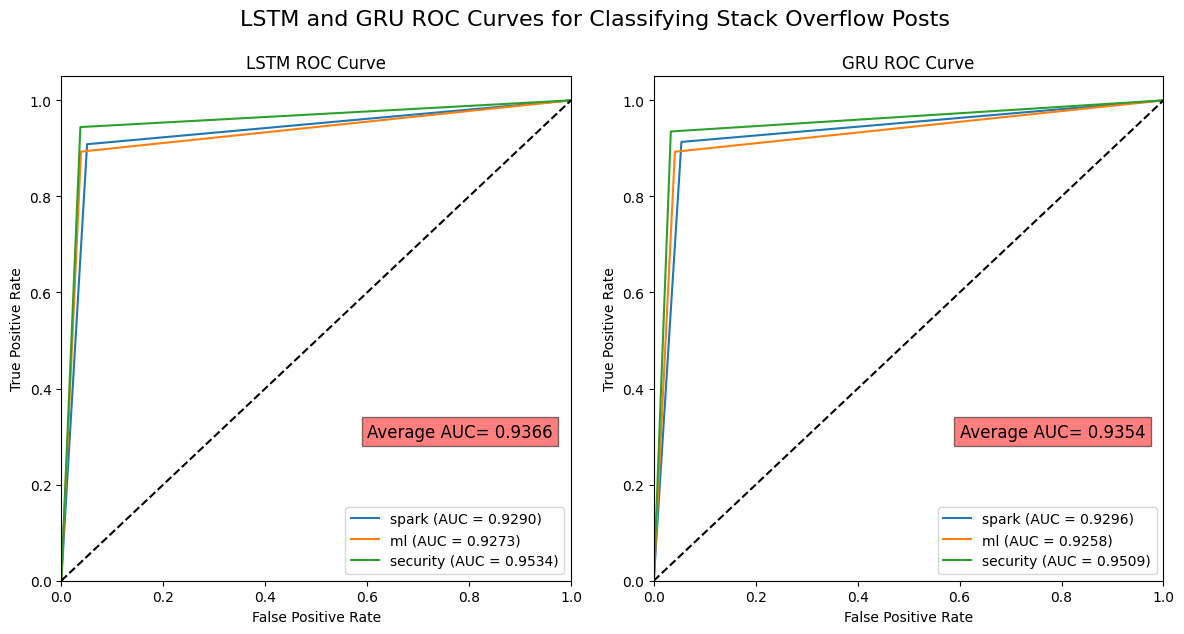

In [39]:
plot_separate_roc_curves(lstm_fpr, lstm_tpr, lstm_roc_auc, gru_fpr, gru_tpr, gru_roc_auc)

Proceed with performing hyperparameter tuning on LSTM model since the average AUC between all three classes is higher.

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrices(true_labels, pred_labels_lstm, pred_labels_gru):
    """
    This function plots the confusion matrices for the LSTM and GRU classifiers.
    
    Parameters:
    true_labels (list): The list of true labels for the test dataset.
    pred_labels_lstm (list): The list of predicted labels by the LSTM classifier.
    pred_labels_gru (list): The list of predicted labels by the GRU classifier.
    """
    labels = list(label_to_idx.keys())
    lstm_cm = confusion_matrix(true_labels, pred_labels_lstm)
    gru_cm = confusion_matrix(true_labels, pred_labels_gru)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax, model_name, cm in zip(axes, ['LSTM', 'GRU'], [lstm_cm, gru_cm]):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=labels, yticklabels=labels)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"{model_name} Confusion Matrix")
    
    plt.tight_layout()
    plt.suptitle("Confusion Matrices for LSTM and GRU Models for Stack Overflow Post Classification", y=1.05)
    plt.show()

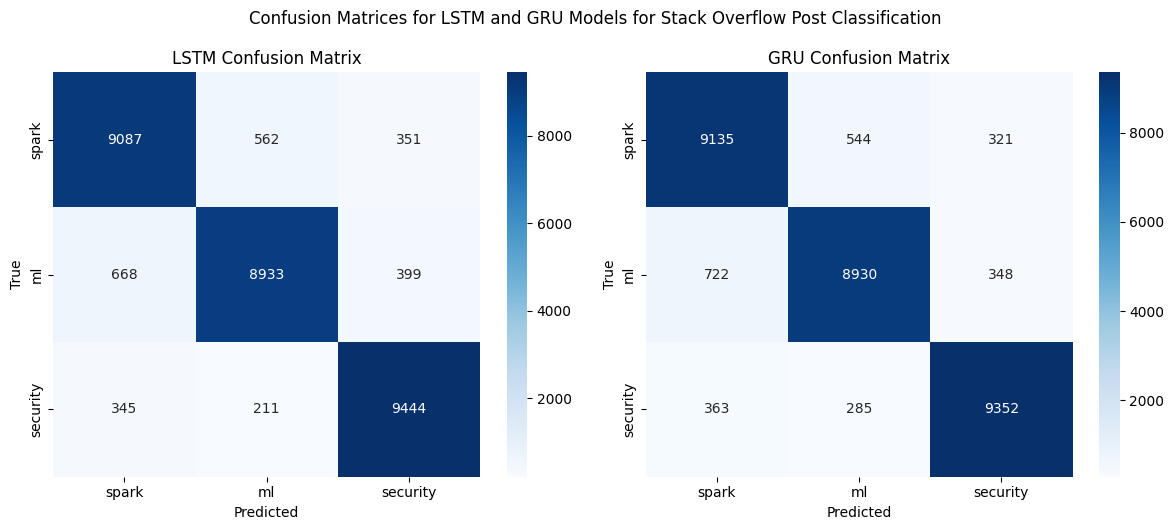

In [37]:
plot_confusion_matrices(lstm_true_labels, lstm_pred_labels, gru_pred_labels)

## Hyperparameter tuning
Perform hyperparameter tuning on LSTM model

In [40]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

# Define hyperparameter search space
param_grid = {
    "hidden_dim": [64, 128, 256],
    "dropout": [0.3, 0.5, 0.7]
}
param_combinations = list(ParameterGrid(param_grid))

def hyperparameter_tuning(model_class, param_combinations):
    """
    This function performs hyperparameter tuning on the given model class using a grid search.
    
    Parameters:
    model_class (class): The class of the model to be tuned, e.g., LSTMClassifier or GRUClassifier.
    param_combinations (list): A list of dictionaries, each representing a combination of hyperparameters.
    
    Returns:
    best_model (object): The best model with the optimal hyperparameters.
    best_params (dict): A dictionary containing the optimal hyperparameters.
    best_true_labels (list): The list of true labels used for evaluation.
    best_pred_labels (list): The list of predicted labels by the best model.
    """
    best_model = None
    best_params = None
    best_f1 = -1
    best_true_labels = None
    best_pred_labels = None

    for params in param_combinations:
        model = model_class(embed_dim, params["hidden_dim"], num_classes, dropout=params["dropout"])
        true_labels, pred_labels = train_and_evaluate(model)
        f1 = f1_score(true_labels, pred_labels, average="weighted")
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = params
            best_true_labels = true_labels
            best_pred_labels = pred_labels
    return best_model, best_params, best_true_labels, best_pred_labels

lstm_best_model, lstm_best_params, lstm_true_labels, lstm_best_pred_labels = hyperparameter_tuning(LSTMClassifier, param_combinations)
print("Best LSTM parameters:", lstm_best_params)

Epoch 1/10 | Train Loss: 0.3866 | Val Loss: 0.2958
Epoch 2/10 | Train Loss: 0.2710 | Val Loss: 0.2545
Epoch 3/10 | Train Loss: 0.2389 | Val Loss: 0.2568
Epoch 4/10 | Train Loss: 0.2221 | Val Loss: 0.2350
Epoch 5/10 | Train Loss: 0.2079 | Val Loss: 0.2343
Epoch 6/10 | Train Loss: 0.1970 | Val Loss: 0.2253
Epoch 7/10 | Train Loss: 0.1873 | Val Loss: 0.2307
Epoch 8/10 | Train Loss: 0.1783 | Val Loss: 0.2313
Epoch 9/10 | Train Loss: 0.1704 | Val Loss: 0.2399
Epoch 10/10 | Train Loss: 0.1630 | Val Loss: 0.2462
Epoch 1/10 | Train Loss: 0.3736 | Val Loss: 0.2791
Epoch 2/10 | Train Loss: 0.2612 | Val Loss: 0.2708
Epoch 3/10 | Train Loss: 0.2310 | Val Loss: 0.2399
Epoch 4/10 | Train Loss: 0.2119 | Val Loss: 0.2396
Epoch 5/10 | Train Loss: 0.1950 | Val Loss: 0.2333
Epoch 6/10 | Train Loss: 0.1817 | Val Loss: 0.2340
Epoch 7/10 | Train Loss: 0.1682 | Val Loss: 0.2409
Epoch 8/10 | Train Loss: 0.1566 | Val Loss: 0.2516
Epoch 9/10 | Train Loss: 0.1440 | Val Loss: 0.2554
Epoch 10/10 | Train Loss: 0.13

In [43]:
from sklearn.metrics import classification_report

print('LSTM Tuned Model Performance:')
print(classification_report(lstm_true_labels, lstm_best_pred_labels, target_names=label_to_idx.keys(), digits=4))

LSTM Tuned Model Performance:
              precision    recall  f1-score   support

       spark     0.9058    0.9006    0.9032     10000
          ml     0.9020    0.9102    0.9061     10000
    security     0.9367    0.9335    0.9351     10000

    accuracy                         0.9148     30000
   macro avg     0.9148    0.9148    0.9148     30000
weighted avg     0.9148    0.9148    0.9148     30000



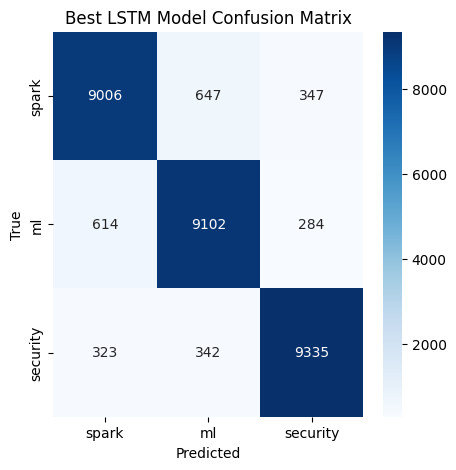

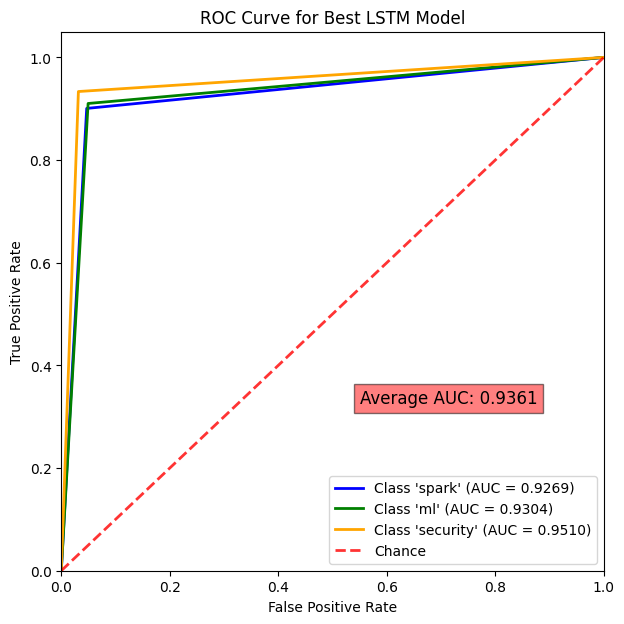

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute the confusion matrix
best_lstm_cm = confusion_matrix(lstm_true_labels, lstm_best_pred_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(best_lstm_cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Best LSTM Model Confusion Matrix")
plt.show()

# Compute ROC curve and ROC area for each class
y_true_bin = label_binarize(lstm_true_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(lstm_best_pred_labels, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average TPR and compute AUC
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Calculate the average AUC
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve with individual classes
plt.figure(figsize=(7, 7))
colors = ['blue', 'green', 'orange']
class_names = list(label_to_idx.keys())

for i, color, class_name in zip(range(num_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class '{class_name}' (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Best LSTM Model")
plt.legend(loc="lower right")

# Display the average AUC on the graph with a red box
plt.text(0.55, 0.325, f"Average AUC: {average_auc:.4f}", fontsize=12, bbox=dict(facecolor="red", alpha=0.5))

plt.show()

## Results

In selecting RNN models, LSTM and GRU were considered beacuse they are both popular types of RNNs that excel at text classification tasks. I decided to compare the performance between the two models through a series comparison of ROC curves, confusion matrices, and classification reports.

The slightly higher average AUC in the LSTM ROC curve tells us that this model slightly outperforms GRU model when it comes to comparison between all three classes.

Confusion matrices and Classification report also slightly favour LSTM over GRU.


### Receiver Operating Characteristic (ROC) curves

| LSTM Model | GRU Model | Tuned LSTM Model (ndim=256, dr=0.3) |
|------------|-----------|-----------------------------------------------|
| ![LSTM ROC](assets/lstm_roc.png) | ![GRU ROC](assets/gru_roc.png) | ![Tuned LSTM ROC](assets/tuned_lstm_roc.png) |

### Confusion matrices

| LSTM Model | GRU Model | Tuned LSTM Model (ndim=256, dr=0.3) |
|------------|-----------|-----------------------------------------------|
| ![LSTM CM](assets/lstm_cm.png) | ![GRU CM](assets/gru_cm.png) | ![Tuned LSTM CM](assets/tuned_lstm_cm.png) |


### Classification report

```
LSTM Model Performance:
              precision    recall  f1-score   support

       spark     0.9111    0.8986    0.9048     10000
          ml     0.9085    0.9051    0.9068     10000
    security     0.9239    0.9400    0.9319     10000

    accuracy                         0.9146     30000
   macro avg     0.9145    0.9146    0.9145     30000
weighted avg     0.9145    0.9146    0.9145     30000
```

```
GRU Model Performance:
              precision    recall  f1-score   support

       spark     0.8998    0.9075    0.9036     10000
          ml     0.9018    0.9014    0.9016     10000
    security     0.9392    0.9315    0.9353     10000

    accuracy                         0.9135     30000
   macro avg     0.9136    0.9135    0.9135     30000
weighted avg     0.9136    0.9135    0.9135     30000

```

```
LSTM Tuned Model Performance:
 precision    recall  f1-score   support

       spark     0.8868    0.9228    0.9044     10000
          ml     0.9127    0.9021    0.9074     10000
    security     0.9530    0.9254    0.9390     10000

    accuracy                         0.9168     30000
   macro avg     0.9175    0.9168    0.9169     30000
weighted avg     0.9175    0.9168    0.9169     30000
```

## Interpretation
*i. As described in the proposal, was the question answered/topic investigated and how?*

The project aimed to deepen the understanding of natural language processing and recurrent neural networks by implementing a topic classification model for categorizing Stack Overflow questions into Spark, ML, or Security. This goal was successfully achieved through a systematic approach that involved the use of the PyTorch framework and RNN-based models, specifically LSTMs or GRUs, for handling sequential text data. High levels of accuracy, precision, recall, and F1-score across all categories demonstrated the effectiveness of the developed model. The positive outcomes highlight the proficiency of RNN-based models in processing sequential text data and capturing the inherent structure and dependencies in natural language.

A practical application of this model is to assist users in determining the appropriate category for posting their questions on Stack Overflow. By effectively categorizing questions, the model can enhance the user experience, guiding users to the correct category and facilitating quicker, more accurate responses from the community.

## Reflection

*i. Why did you select this problem to solve?*

I selected this problem to solve as it allowed me to learn and reinforce my understanding of NLP, and to apply it in different domains. I had previously used NLP in the context of Spark, but never with PyTorch. Additionally, I was interested in learning more about neural networks and the PyTorch framework, so this project provided a perfect opportunity for me to delve into these topics.



*ii. Were there any deviations from your proposal? Explain why (or why not).*

There were no significant deviations from the original project proposal. I followed a project guide based on Amazon reviews, which provided a solid foundation for building my project. This allowed me to focus on understanding and applying NLP and PyTorch concepts effectively throughout the project.

*iii. What did you find difficult about this project? What did you find easy? What did you learn?*

The most challenging aspect of this project was preprocessing the data, as it contained a lot of noise and required careful NLP text preprocessing. Converting between different data types such as strings, vectors, and tensors while ensuring the types are valid was particularly tricky.

On the other hand, I found designing the model and building the training loop relatively easy, since I could consult various sources for guidance, and the process of using PyTorch for machine learning appeared to be consistent across different cases. This allowed me to focus on the specific aspects of NLP and RNN-based models without getting bogged down in the details of the machine learning process itself.

Throughout this project, I learned a great deal about natural language processing, RNNs (specifically LSTMs and GRUs), and the PyTorch framework. The hands-on experience helped me gain a deeper understanding of the challenges and intricacies associated with NLP and text data. I also learned about the importance of data preprocessing and the various techniques that can be employed to clean and prepare text data for model training. Furthermore, I gained valuable experience in implementing and training neural network models using PyTorch and evaluating their performance.

Overall, this project has significantly increased my familiarity with PyTorch and deep learning, serving as an excellent stepping stone for further exploration of these topics. I thoroughly enjoyed applying the concepts learned in class to create my own machine learning models and look forward to building on this experience in future projects.
